In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the XOR Dataset
		according to the tensorflow playground website
	

In [95]:
def custom_xor(x,y):
    if x*y >= 0:
        return 1
    else:
        return -1
def pad_data(x):
    p = 0.3
    if x>0:
        return x+p
    else:
        return x-p
def rand_uniform(a,b):
    r = np.random.rand()
    r = r*(b-a)+a
    return r
def generate_xor_dataset(numsamples,noise=0):
    data = []
    padding = 0.3
    for i in range(numsamples):
        x = rand_uniform(-5,5)
        y = rand_uniform(-5,5)
        x = pad_data(x)
        y = pad_data(y)
        noiseX = rand_uniform(-5,5)*noise
        noiseY = rand_uniform(-5,5)*noise
        # x,y = x+noiseX,y+noiseY
        label = custom_xor(x+noiseX,y+noiseY)
        data.append([x,y,label])
    # data = np.array(data)
    return data
        

In [96]:
data_0 = generate_xor_dataset(400)

In [105]:
def plot_data(data):#Function to plot data with 2 features and 2 labels
	data = np.array(data)
	X = data[:,:2]
	y = data[:,2]
	colors = ['blue' if label == 1 else 'orange' for label in y]
	plt.scatter(X[:,0],X[:,1], c = colors,marker='.')
	plt.axhline(0, color='gray', linewidth=1, linestyle='-')  # X-axis line at y=0
	plt.axvline(0, color='gray', linewidth=1, linestyle='-')  # Y-axis line at x=0
	plt.show()

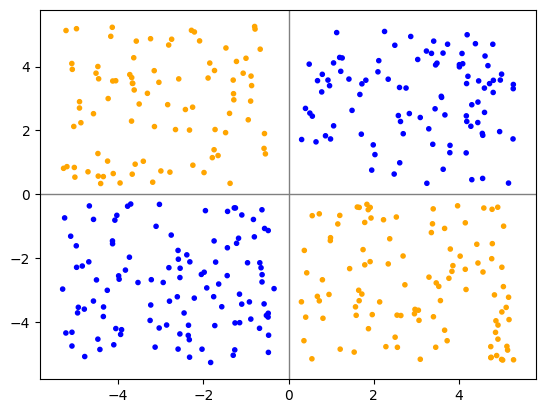

In [106]:
plot_data(data_0)

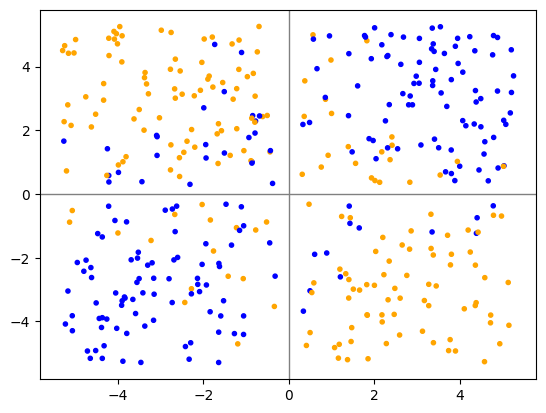

In [107]:
data_05 = generate_xor_dataset(400,0.5)
plot_data(data_05)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F